# Analyzing the contrast maps

## Imports

In [1]:
import sys
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install scipy
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install h5py
#!{sys.executable} -m pip install nibabel
#!{sys.executable} -m pip install opencv-python
#!{sys.executable} -m pip install pycocotools
#!{sys.executable} -m pip install scikit-learn
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import h5py
import nibabel as nib
import cv2
from pycocotools.coco import COCO
import time
import collections
import csv
import sklearn
import multiprocessing as mp

## Useful functions

In [2]:
def load_from_nii(mask_nii_file):
    return nib.load(mask_nii_file).get_fdata()

In [12]:
subject = 1

exp_design = scipy.io.loadmat('nsd_expdesign.mat')
ordering = exp_design['masterordering'].flatten() - 1 #fix indexing
trials = np.array([30000, 30000, 24000, 22500, 30000, 24000, 30000, 22500])
data_size = trials[subject-1]
ordering_data = ordering[:data_size]
subjectim = exp_design['subjectim'] - 1

f = h5py.File('S'+str(subject)+'_stimuli_227.h5py','r')
images = f['stimuli']

coco = COCO('annotations/instances_train2017.json')
coco2 = COCO('annotations/instances_val2017.json')
coco3 = COCO('annotations/captions_train2017.json')
coco4 = COCO('annotations/captions_val2017.json')

def index_to_image(my_index):
    index = ordering[my_index]
    image = images[index,:,:,:]
    return np.transpose(image, (1,2,0))

def load_csv(csv_file):
    file = open(csv_file)
    csvreader = csv.reader(file)
    header = next(csvreader)
    rows = []
    for row in csvreader:
        rows.append(row)
    file.close()
    return rows

nsd_to_coco = load_csv('nsd_stim_info_merged.csv')

def index_to_label(my_index):
    index = ordering_data[my_index]
    nsd_id = subjectim[subject-1,index]
    coco_id = nsd_to_coco[nsd_id][1]
    
    img_id_train = []
    img_id_val = []
    if int(nsd_id) < 2950:
        img_id_val.append(int(coco_id))
    else:
        img_id_train.append(int(coco_id))
    local = collections.Counter()
    if len(img_id_train) != 0:
        annotation_ids = coco.getAnnIds(img_id_train)
        annotations = coco.loadAnns(annotation_ids)
        for i in range(len(annotations)):
            entity_id = annotations[i]["category_id"]
            entity = coco.loadCats(entity_id)[0]["name"]
            local[entity] += 1
    if len(img_id_val) != 0:
        annotation_ids = coco2.getAnnIds(img_id_val)
        annotations = coco2.loadAnns(annotation_ids)
        for i in range(len(annotations)):
            entity_id = annotations[i]["category_id"]
            entity = coco2.loadCats(entity_id)[0]["name"]
            local[entity] += 1
    return local

def index_to_captions(my_index):
    index = ordering_data[my_index]
    nsd_id = subjectim[subject-1,index]
    coco_id = nsd_to_coco[nsd_id][1]
    if int(nsd_id) < 2950:
        annotation_ids = coco4.getAnnIds(int(coco_id))
        annotations = coco4.loadAnns(annotation_ids)
    else:
        annotation_ids = coco3.getAnnIds(int(coco_id))
        annotations = coco3.loadAnns(annotation_ids)
    captions = [item['caption'] for item in annotations]
    return captions    

loading annotations into memory...
Done (t=28.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.80s)
creating index...
index created!
loading annotations into memory...
Done (t=2.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [4]:
def get_all_labels():    
    all_labels = collections.Counter()
    for i in range(30000):
        all_labels.update(index_to_label(i))
    all_labels = list(all_labels.keys())
    all_labels.sort()
    return all_labels

all_labels = get_all_labels()        

In [5]:
def get_counts():   
    all_counts = np.empty((80,30000))
    for trial in range(30000):
        label_counter = index_to_label(trial)
        for index, label in enumerate(all_labels):
            label_count = label_counter[label]
            all_counts[index,trial] = label_count
    return all_counts

all_counts = get_counts()

In [6]:
loaded_data_all, loaded_session_all = None, 0

def get_all_contrast_maps():
    #getting alphabetized list of the 80 labels
    all_labels = get_all_labels()
    
    #getting label counts into a giant matrix
    all_counts = get_counts()
    
    positive_resultant = np.zeros((81,104,83,80))
    #negative_resultant = np.zeros((81,104,83,80))
    global loaded_data_all
    global loaded_session_all
    
    positive_denominators = np.zeros(80)
    #negative_denominators = np.zeros(80)
    for session in range(40):
        
        time_3 = time.time()
        
        session += 1
        if session != loaded_session_all:
            if session < 10:
                loaded_data_all = load_from_nii("betas/subj0"+str(subject)+"/betas_session0"+str(session)+".nii")
                loaded_session_all = session
            else:
                loaded_data_all = load_from_nii("betas/subj0"+str(subject)+"/betas_session"+str(session)+".nii")
                loaded_session_all = session
        trial_end = 750*session
        trial_start = trial_end - 750
        for label_index in range(80):
            row = all_counts[label_index,trial_start:trial_end]
            positive_condition = (row == 0)
            #negative_condition = (row == 0)
            for positive in positive_condition:
                positive_denominators[label_index] += 1
            #for negative in negative_condition:
            #    negative_denominators[label_index] += 1
            local_positive_resultant = np.sum(loaded_data_all[:,:,:,positive_condition], axis=3)
            #local_negative_resultant = np.sum(loaded_data_all[:,:,:,negative_condition], axis=3)
            positive_resultant[:,:,:,label_index] = positive_resultant[:,:,:,label_index] + local_positive_resultant
            #negative_resultant[:,:,:,label_index] = negative_resultant[:,:,:,label_index] + local_negative_resultant
        print((time.time() - time_3)/60)
                    
    positive_resultant = positive_resultant.astype('float')
    #negative_resultant = negative_resultant.astype('float')
    
    for label_index in range(80):
        if positive_denominators[label_index] != 0:
            positive_resultant[:,:,:,label_index] = positive_resultant[:,:,:,label_index] / positive_denominators[label_index]
        #if negative_denominators[label_index] != 0:
        #    negative_resultant[:,:,:,label_index] = negative_resultant[:,:,:,label_index] / negative_denominators[label_index]
    
    #return positive_resultant - negative_resultant
    return positive_resultant

In [7]:
def label_to_contrast_map(label):
    return all_contrast_maps[:,:,:,all_labels.index(label)]

In [8]:
def label_to_images(label, at_most=30000):
    label_index = all_labels.index(label)
    i = 0
    row = all_counts[label_index,:]
    print(str((row>0).sum()) + " total images with "+label+"!")
    for trial, count in enumerate(row):
        if count > 0 and i < at_most:
            plt.imshow(index_to_image(trial))
            print(trial)
            plt.show()
            i += 1

# Analysis

Available functions: <br/>
>index_to_image(my_index) <br/>
<br/>
index_to_label(my_index) <br/>
<br/>
label_to_contrast_map(label) <br/>
<br/>
label_to_images(label, at_most=30000)

where my_index is relative to 30K, label is a string, and at_most is the limit on number of images displayed

In [9]:
all_contrast_maps = load_from_nii('all_contrast_maps.nii')

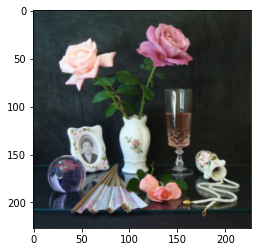

Counter({'vase': 2, 'wine glass': 1, 'person': 1})


In [10]:
plt.imshow(index_to_image(4590))
plt.show()
print(index_to_label(4590))


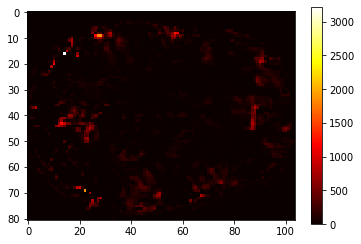

579 total images with wine glass!


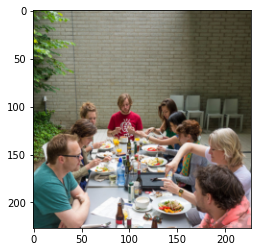

In [11]:
plt.imshow(label_to_contrast_map('wine glass')[:,:,40], cmap='hot', vmin=0, interpolation='None')
plt.colorbar()
plt.show()


label_to_images('wine glass',1)

## t-SNE and Principal Components Analysis

In [12]:
vectorized_acm = all_contrast_maps.reshape(81*104*83, 80).transpose()
vectorized_acm.shape

(80, 699192)

Still need to closer analysis of PCA: variance explained, optimal n_dim, etc.

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=80)
pca.fit(vectorized_acm)
representations = pca.transform(vectorized_acm)
representations.shape

(80, 80)

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(representations)
X_embedded.shape

(80, 2)

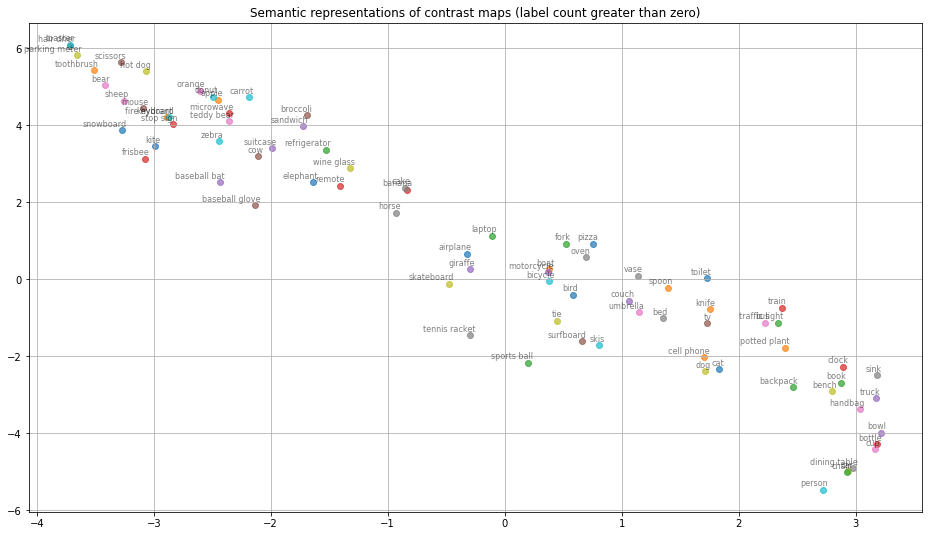

In [15]:
def tsne_plot_similar_words(title, labels, embedding_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    #colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings in zip(labels, embedding_clusters):#, colors):
        x = embeddings[0]
        y = embeddings[1]
        plt.scatter(x, y, alpha=a)
        plt.annotate(label, alpha=0.5, xy=(x, y), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=8)
    plt.title(title)
    plt.grid(True)
    plt.show()


tsne_plot_similar_words('Semantic representations of contrast maps (label count greater than zero)', all_labels, X_embedded, 0.7)


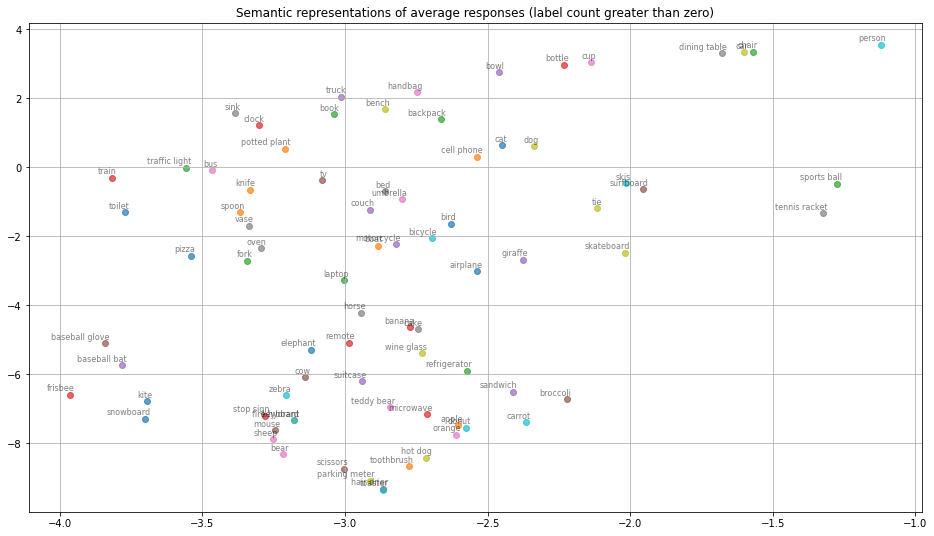

In [16]:
#average response for 
average_response_maps = load_from_nii('average_response_maps.nii')
vectorized_arm = average_response_maps.reshape(81*104*83, 80).transpose()
pca = PCA(n_components=80)
pca.fit(vectorized_arm)
representations_2 = pca.transform(vectorized_arm)
X_embedded_2 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(representations_2)
tsne_plot_similar_words('Semantic representations of average responses (label count greater than zero)', all_labels, X_embedded_2, 0.7)

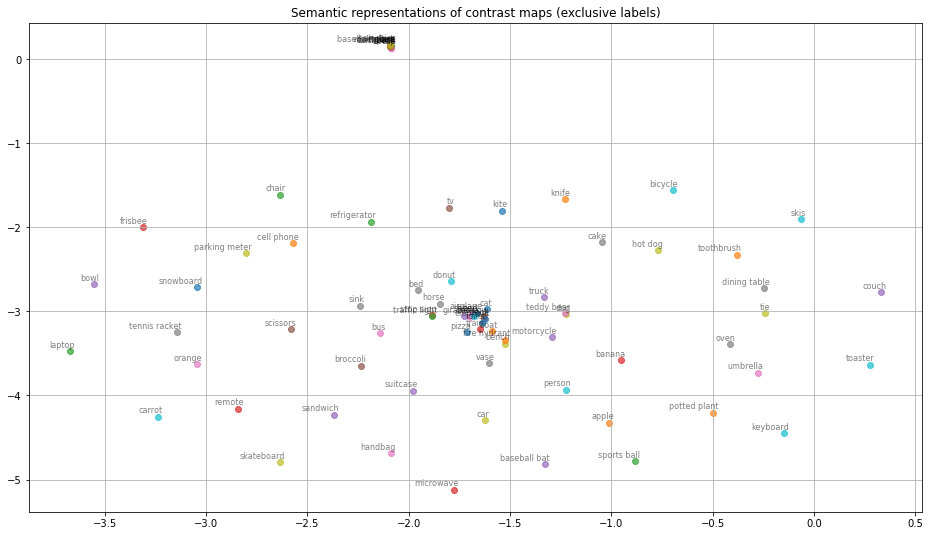

In [17]:
exclusive_label_contrast_maps = load_from_nii('exclusive_label_contrast_maps.nii')
vectorized_elcm = exclusive_label_contrast_maps.reshape(81*104*83, 80).transpose()
pca = PCA(n_components=80)
pca.fit(vectorized_elcm)
representations_3 = pca.transform(vectorized_elcm)
X_embedded_3 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(representations_3)
tsne_plot_similar_words('Semantic representations of contrast maps (exclusive labels)', all_labels, X_embedded_3, 0.7)

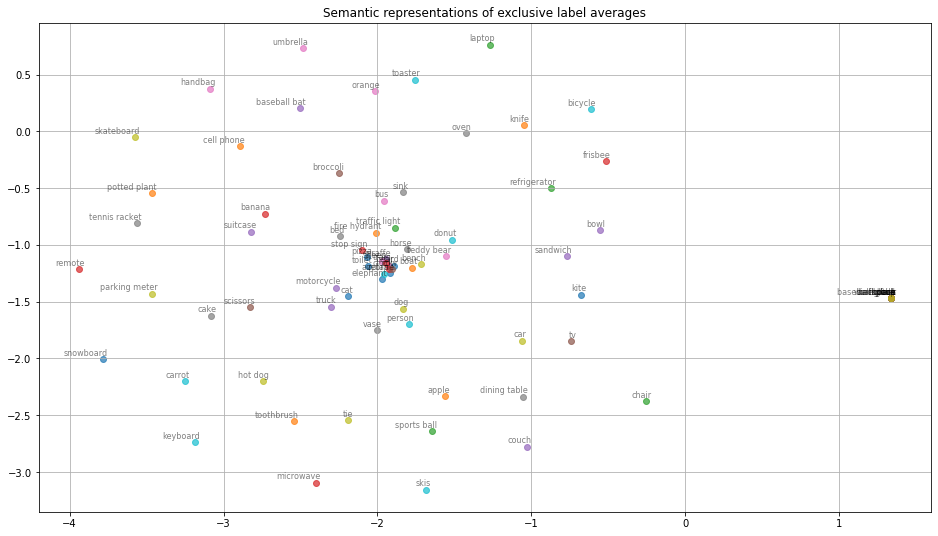

In [18]:
exclusive_label_averages = load_from_nii('exclusive_label_averages.nii')
vectorized_ela = exclusive_label_averages.reshape(81*104*83, 80).transpose()
pca = PCA(n_components=80)
pca.fit(vectorized_ela)
representations_4 = pca.transform(vectorized_ela)
X_embedded_4 = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(representations_4)
tsne_plot_similar_words('Semantic representations of exclusive label averages', all_labels, X_embedded_4, 0.7)

Dig into theory: is it possible that additive constant meaningless for tsne?

Idea: learning the voxel decoding using word embedding as training signal
-> Rather than PCA, then linear decoding, why not learn nonlinear dimensionality reduction

## Additive compositionality hypothesis

DON'T do NN in high dimensions

In [9]:
def nearest_neighbor(brain_vector):
    brain_vector = brain_vector.flatten()
    distances = np.ones(10)*999999999999999999999
    indices = np.zeros(10)
    for session in range(40):
        start = time.time()
        session += 1
        if session < 10:
            loaded_data = load_from_nii("betas/subj0"+str(subject)+"/betas_session0"+str(session)+".nii")
        else:
            loaded_data = load_from_nii("betas/subj0"+str(subject)+"/betas_session"+str(session)+".nii")
        for trial in range(750):
            dist = scipy.spatial.distance.cosine(loaded_data[:,:,:,trial].flatten(), brain_vector)
            #np.linalg.norm(loaded_data[:,:,:,trial] - brain_vector)
            idx = 750*(session-1) + trial
            for n in range(10):
                if dist < distances[n]:
                    distances[n] = dist
                    indices[n] = idx
                    break
        print(time.time() - start)
    indices = indices.astype('int')
    return distances, indices

8.47033953666687
8.986529111862183
7.723803997039795
7.598161935806274
7.60427713394165
7.676671981811523
7.714935064315796
7.580053806304932
7.858758211135864
7.653006553649902
8.0819091796875
7.547086954116821
7.914315462112427
7.601485252380371
7.87427544593811
7.554975271224976
7.752845048904419
7.519549131393433
7.7500224113464355
7.521441698074341
7.687046527862549
7.62412166595459
7.9406750202178955
7.586703300476074
7.8683319091796875
7.593618631362915
7.799587726593018
7.3986852169036865
7.404793739318848
7.226759195327759
7.378819704055786
7.1469128131866455
7.350383520126343
7.208661794662476
7.386568546295166
7.259477376937866
7.4305031299591064
7.31508469581604
7.424121618270874
7.150611162185669


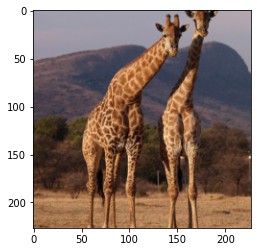

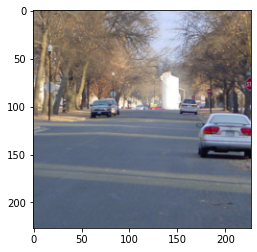

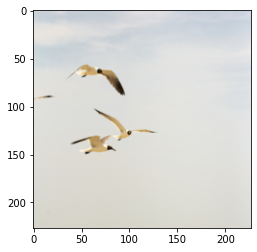

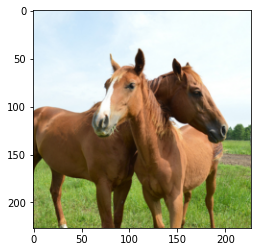

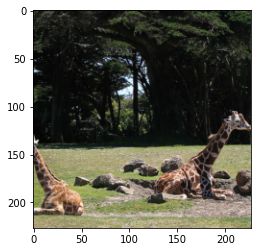

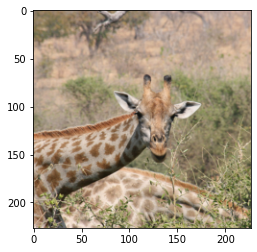

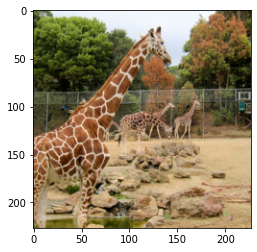

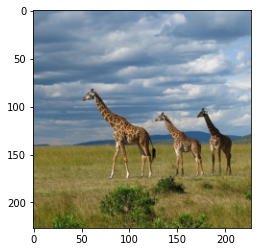

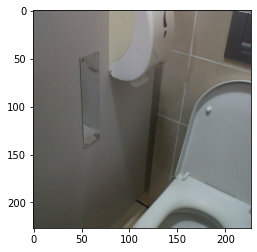

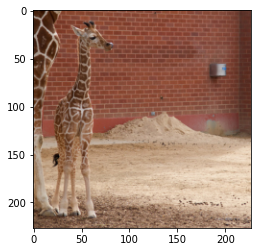

In [22]:
dists, idxs = nearest_neighbor(exclusive_label_contrast_maps[:,:,:,all_labels.index('giraffe')])
for idx in idxs:
    plt.imshow(index_to_image(idx))
    plt.show()

5.093335866928101
4.863970756530762
5.031536817550659
4.801628351211548
4.935087203979492
4.760408163070679
4.893714666366577
4.711428642272949
4.8426833152771
4.693725347518921
4.808207750320435
4.672999143600464
4.772496223449707
4.653241157531738
4.739868640899658
4.641216993331909
4.718290090560913
4.6394829750061035
4.700427293777466
4.620980978012085
4.685903787612915
4.626024484634399
4.676736116409302
4.615759372711182
4.663713455200195
4.615536212921143
4.653977394104004
4.6186065673828125
4.648219585418701
4.606992721557617
4.647176027297974
4.606062412261963
4.63456392288208
4.607682704925537
4.633194446563721
4.60642409324646
4.634933710098267
4.609021902084351
4.630491256713867
4.605961561203003


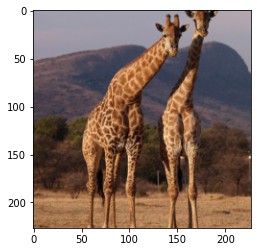

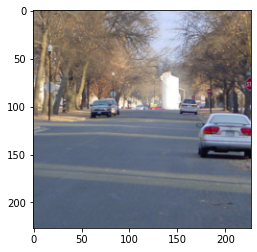

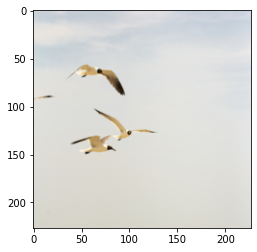

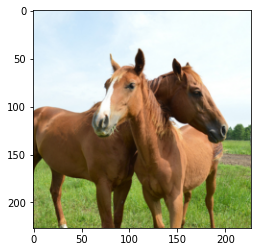

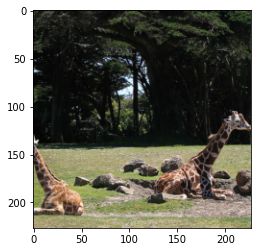

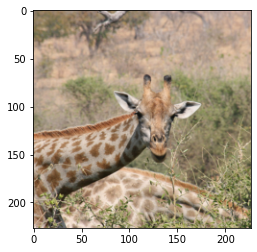

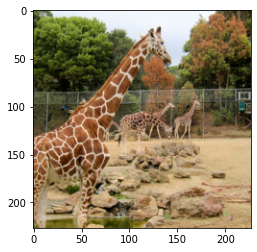

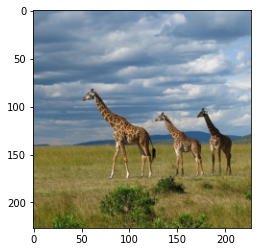

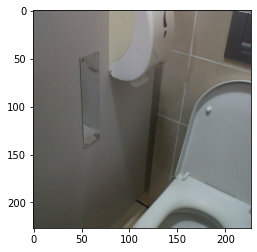

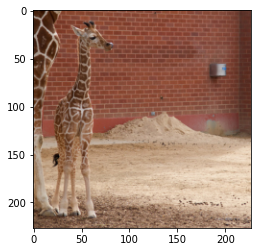

In [52]:
dists, idxs = nearest_neighbor(exclusive_label_contrast_maps[:,:,:,all_labels.index('giraffe')])
for idx in idxs:
    plt.imshow(index_to_image(idx))
    plt.show()

In [53]:
idxs

array([ 8843,  8887,  8888,  8954, 15066, 13142, 28870, 29769, 29566,
       29787])

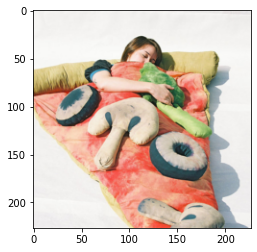

In [76]:
plt.imshow(index_to_image(8841))
plt.show()

4.651033639907837
5.237719535827637
4.67035698890686
5.120635032653809
4.668752670288086
5.027978181838989
4.667325258255005
4.97012996673584
4.659242630004883
4.909242630004883
4.6572325229644775
4.859506130218506
4.646843910217285
4.827022075653076
4.65824818611145
4.798216104507446
4.66045880317688
4.772773027420044
4.656622886657715
4.761059045791626
4.659786701202393
4.739286661148071
4.658825397491455
4.727621078491211
4.655754327774048
4.718862771987915
4.659304141998291
4.709444999694824
4.6562628746032715
4.710627794265747
4.658786058425903
4.703535079956055
4.659076452255249
4.69389009475708
4.655134916305542
4.691729307174683
4.660786390304565
4.696739673614502
4.657268047332764
4.688507795333862


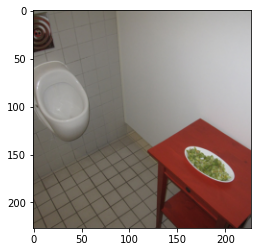

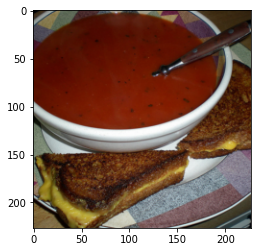

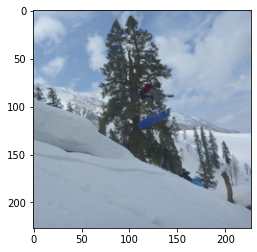

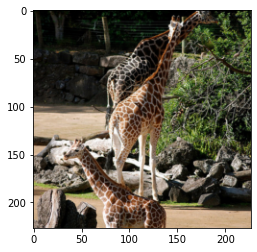

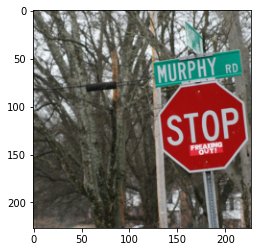

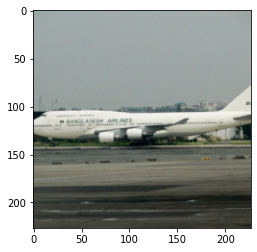

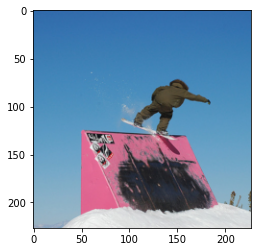

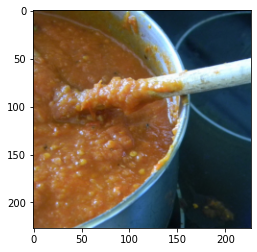

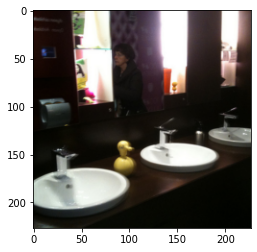

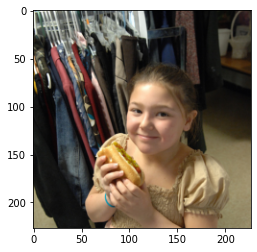

In [49]:
session_1 = load_from_nii('betas/subj01/betas_session01.nii')
dists, idxs = nearest_neighbor(session_1[:,:,:,122])
for idx in idxs:
    plt.imshow(index_to_image(idx))
    plt.show()

In [45]:
idxs

array([120, 121,  96, 117, 147, 311, 377, 275, 442, 678])

In [48]:
idxs

array([121, 122, 123, 126, 154, 213, 265, 316, 381, 734])

In [51]:
idxs

array([  122,   123,   124,   126,  5372,   269, 22204, 22205, 11113,
        4129])

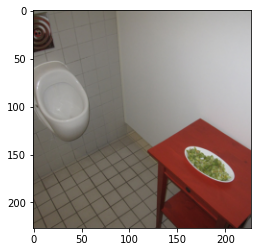

In [50]:
plt.imshow(index_to_image(122))
plt.show()

Closest representation to 120 is itself and then 121! Images aren't related. Possible that artifacts aren't taken away sufficiently? ALSO, all are within the same session (session 1)!! Edit: 121 is even worse! Closest are 122 followed by 123! Again remains within very close time span and doesn't touch any other sessions!

## Positive condition is one label

In [26]:
#one_label_average = get_all_contrast_maps(1)
#zero_label_average = get_all_contrast_maps(0)
#one_label_contrast_maps = one_label_average - zero_label_average
#one_label_contrast_nifti = nib.Nifti1Image(one_label_contrast_maps, affine=np.eye(4))
#nib.save(one_label_contrast_nifti, 'one_label_contrast_maps.nii')

# Todo

Nilearn plotting glass brain

t stat to measure variance among voxels

Images with only one label

Weighting by size of annotations

# Exclusive labels

Counter({'giraffe': 600, 'clock': 462, 'zebra': 420, 'airplane': 417, 'bird': 393, 'elephant': 384, 'train': 381, 'toilet': 333, 'cow': 312, 'bear': 282, 'sheep': 219, 'horse': 189, 'pizza': 168, 'stop sign': 156, 'traffic light': 150, 'boat': 147, 'cat': 147, 'bench': 138, 'person': 123, 'dog': 117, 'fire hydrant': 117, 'bed': 108, 'teddy bear': 108, 'donut': 102, 'motorcycle': 102, 'truck': 96, 'vase': 96, 'bus': 90, 'sink': 90, 'broccoli': 69, 'banana': 66, 'scissors': 57, 'suitcase': 57, 'cake': 42, 'car': 42, 'apple': 36, 'kite': 36, 'hot dog': 33, 'oven': 33, 'sandwich': 33, 'cell phone': 30, 'refrigerator': 30, 'parking meter': 24, 'umbrella': 24, 'orange': 21, 'bicycle': 18, 'remote': 18, 'tv': 18, 'carrot': 15, 'skateboard': 15, 'tie': 15, 'keyboard': 12, 'microwave': 12, 'toothbrush': 12, 'bowl': 9, 'frisbee': 9, 'handbag': 9, 'knife': 9, 'skis': 9, 'chair': 6, 'dining table': 6, 'laptop': 6, 'snowboard': 6, 'toaster': 6, 'baseball bat': 3, 'couch': 3, 'potted plant': 3, 'spo

<BarContainer object of 80 artists>

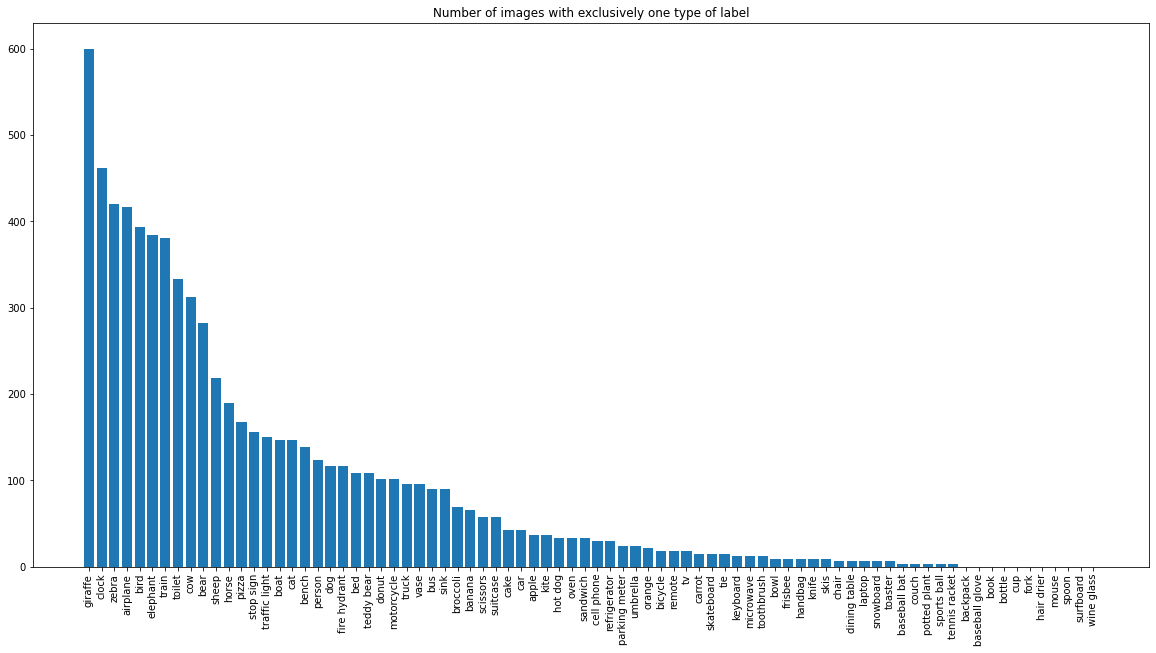

In [34]:
def get_exclusive_labels():    
    keep = []
    for i in range(30000):
        distinct_labels = 0
        for j in range(80):
            if all_counts[j,i] != 0:
                distinct_labels += 1
        if distinct_labels == 1:
            keep.append(i)

    distinct_counts = np.where(all_counts[:,keep] > 0, 1, 0)
    distinct_counts = np.sum(distinct_counts, axis=1)
    totals = collections.Counter()
    for label_index, label in enumerate(all_labels):
        totals[label] = distinct_counts[label_index]
    return keep, totals

keep, totals = get_exclusive_labels()
#totals is a counter that maps labels to number of images with that exclusive label
#keep is a list of indices relative to 30K that give exclusive label trials

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
print(totals)
xs, ys  = zip(*list(totals.most_common()))
plt.title('Number of images with exclusively one type of label')
plt.bar(xs,ys)

In [36]:
len(keep)

7305

In [69]:
exclusive = np.where(all_counts[:,keep] > 0, 1, 0)
loaded_data_exclusive, loaded_session_exclusive = None, 0

def get_exclusive_label_contrast_maps():
    
    positive_resultant = np.zeros((81,104,83,80))
    global loaded_data_exclusive
    global loaded_session_exclusive
    
    positive_denominators = np.zeros(80)
    for session in range(40):
        start = time.time()
        session = session + 1
        if session != loaded_session_exclusive:
            if session < 10:
                loaded_data_exclusive = load_from_nii("betas/subj0"+str(subject)+"/betas_session0"+str(session)+".nii")
                loaded_session_exclusive = session
            else:
                loaded_data_exclusive = load_from_nii("betas/subj0"+str(subject)+"/betas_session"+str(session)+".nii")
                loaded_session_exclusive = session

        trial_end = 750*session
        trial_start = trial_end - 750
        
        for exclusive_trial in keep:
            indices = np.nonzero(all_counts[:,exclusive_trial])[0]
            if trial_start <= exclusive_trial < trial_end and len(indices) == 1:
                positive_denominators[indices[0]] += 1
                positive_resultant[:,:,:,indices[0]] = positive_resultant[:,:,:,indices[0]] + loaded_data_exclusive[:,:,:,exclusive_trial%750]
        print(time.time() - start)
                    
    positive_resultant = positive_resultant.astype('float')
    
    for label_index in range(80):
        if positive_denominators[label_index] != 0:
            positive_resultant[:,:,:,label_index] = positive_resultant[:,:,:,label_index] / positive_denominators[label_index]

    return positive_resultant

In [70]:
exclusive_label_averages = get_exclusive_label_contrast_maps()

6.621737718582153
7.48323130607605
5.6405768394470215
6.889146566390991
5.978015661239624
6.800616264343262
5.755694389343262
6.838087320327759
5.7012152671813965
7.9288599491119385
6.895286560058594
7.549081325531006
6.883008718490601
7.087208271026611
6.584409713745117
7.613956689834595
6.778552532196045
7.286430835723877
6.5586302280426025
7.185274600982666
6.259127140045166
7.797122240066528
6.43259859085083
7.5659589767456055
6.975751876831055
6.818876504898071
6.207006454467773
7.247920751571655
6.801170587539673
7.7741076946258545
6.810856580734253
7.244158744812012
6.533147573471069
7.821163177490234
6.89112401008606
7.160353422164917
6.633502006530762
6.159721374511719
6.080672025680542
6.609851121902466


In [85]:
#for i in range(80):
#    r = exclusive_label_averages[:,:,i,all_labels.index('giraffe')]
#    plt.imshow(np.where(r==0, -1001, r), cmap='hot', vmin=-1000,  vmax=1000, interpolation='None')
#    plt.show()

In [87]:
average_exclusive_image = nib.Nifti1Image(exclusive_label_averages, affine=np.eye(4))
nib.save(average_exclusive_image, 'exclusive_label_averages.nii')

In [93]:
zero_label_average = get_all_contrast_maps()
zero_label_average_image = nib.Nifti1Image(zero_label_average, affine=np.eye(4))
nib.save(zero_label_average_image, 'zero_label_averages.nii')
exclusive_label_contrast_maps = exclusive_label_averages - zero_label_average
exclusive_label_contrast_maps_image = nib.Nifti1Image(exclusive_label_contrast_maps, affine=np.eye(4))
nib.save(exclusive_label_contrast_maps_image, 'exclusive_label_contrast_maps.nii')

4.894959823290507
3.8385705868403117
4.849944376945496
3.8349757035573324
4.632267725467682
3.8037517269452414
4.325617019335429
3.7830888549486796
4.3106313665707905
3.76655676762263
4.302452206611633
3.7892404834429425
4.316401731967926
3.754351325829824
4.315151540438334
3.7670231103897094
4.317164866129557
3.756652828057607
4.31341183980306
3.7323393980662027
4.282789055506388
3.795267673333486
4.298435004552205
3.766518215338389
4.3086441119511925
3.7487053871154785
4.298991139729818
3.7515333970387776
4.285685741901398
3.7509992043177287
4.299276638031006
3.828682208061218
4.295565152168274
3.754208513100942
4.308522526423136
3.7542446851730347
4.303534122308095
3.7753267963727315
4.349911757310232
3.76268230676651


In [10]:
for i in range(80):
    plt.imshow(exclusive_label_contrast_maps[:,:,i,all_labels.index('toaster')], vmin=-8000, vmax=8000, cmap='hot', interpolation='None')
    plt.colorbar()
    plt.show()

NameError: name 'exclusive_label_contrast_maps' is not defined

# 